In [23]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../Data/www/styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [29]:
%matplotlib inline

import json
import scipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from scipy.special import erf
from collections import Counter

# Synopsis

In this unit we will discuss how to randomly generate possible data sets from a set of sample data (known as bootstrapping). To do that we will cover:

* Why/when you would need to bootstrap data
* How to bootstrap data
* How to statistically evaluate bootstrapped data

# Bootstrap methods

When doing science, ideally, one would have many replicates of an experiment.  The replicates would enable us to calculate both an expected outcome and the variability in outcomes.  Those quantities would then enable us, under certain assumptions, to estimate the chance that some observed difference from a null model could be explained by chance or not.

But what can we do when we only have one replicate?  This is frequently the case with observational studies, but it can occur in other contexts too.

## Entropy of text

Back when we first analyzed text, I asked the question of whether the play 'Othello' should have been named 'Iago'. That question came from the fact, that at a rudimentary analysis, Iago seems to be the main speaker from a data analysis perspective. 

However, in the exercises we switched to a more complex metric, the entropy, evaluate who was the more articulate speaker (with our idea being that the more articulate speaker may be the main character). When we calculated the entropy Iago had a slightly higher measure than Othello's. The problem is we didn't know how to answer if the **difference was significant**.

This is a common situation - you use all of your available data points to calculate a single metric that encodes some measure or performance of the data. However, this leaves you with only one number for each category (which is essentially just **one observation**) --- there's no way that you can run a t-test with just one observation (at least I hope you would never try)!

What do you do?

## The bootstrap -- or creating ensembles of data

The answer is to bootstrap your data. What this means seems complicated but it actually is very simple, the procedure is as follows:

1. Randomly select individual data points from our source data to create a new synthetic dataset
2. Calculate our metric of interest on the synthetic dataset
3. Repeat steps 1-2 $10^3$ - $10^6$ times (depending on data/metric)
4. Evaluate the distribution of synthetic results to the real value from the data

Put simply, we create lots of *possible* datasets from our observed data and see how our value compares to the *possible* data (or how one set of *possible* data compares to another set of *possible* data).

There are only two ways to sample data to generate synthetic datasets -- **with or without** replacement. 

* **with replacement** when we select a data point to put in our synthetic dataset, we leave it in the original dataset so it could be drawn again
* **without replacement** when we select a data point to put in our synthetic dataset, we remove it from the original dataset so it cannot be drawn again

## What's the difference between these two methods?

Well, it's somewhat hard to give a definition that is both concrete/understandable and general --- but as a guideline:

If you are interested in calculating the difference between two metrics or an observed value against a probable process, you are most likely interested in sampling **with replacement**. To do this you typically keep the synthetic dataset size **fixed** and **equal to the original number of observations**. If you sampled without replacement then you would generate synthetic datasets that are identical to each other and the original dataset.

If you are interested in calculating the relationship between datapoints in time (i.e. one value following another in time), you are more likely intersted in sampling **without replacement**. You're interested not in observing different values, which 'with replacement' would give, but instead if there is a difference in how one data point follows another in time. 

# The entropy of Othello and Iago

To make this concrete, let's recap the entropy of Othello and Iago's dialogue. 

First we have to read in the dialogue and calculate the entropy.

In [123]:
def extract_othello_play():
    '''
    Extracts the othello play from the Shakespeare.txt file
    '''
    complete_works = open('../Data/Day5-Text-Analysis/Shakespeare.txt').read()
    #Cut off the beginning plays
    othello_full = complete_works.split('OTHELLO, MOOR OF VENICE\n\nby William Shakespeare\n\n\n\n')[1]
    #Cut off the plays after
    othello_text = othello_full.split('\n\n\nTHE END')[0]
    #Clean out the electronic message
    emessage = '''<<THIS ELECTRONIC VERSION OF THE COMPLETE WORKS OF WILLIAM\nSHAKESPEARE IS COPYRIGHT 1990-1993 BY WORLD LIBRARY, INC., AND IS\nPROVIDED BY PROJECT GUTENBERG ETEXT OF ILLINOIS BENEDICTINE COLLEGE\nWITH PERMISSION.  ELECTRONIC AND MACHINE READABLE COPIES MAY BE\nDISTRIBUTED SO LONG AS SUCH COPIES (1) ARE FOR YOUR OR OTHERS\nPERSONAL USE ONLY, AND (2) ARE NOT DISTRIBUTED OR USED\nCOMMERCIALLY.  PROHIBITED COMMERCIAL DISTRIBUTION INCLUDES BY ANY\nSERVICE THAT CHARGES FOR DOWNLOAD TIME OR FOR MEMBERSHIP.>>'''
    emessage_split = othello_text.split(emessage)
    #Preamble is the first part
    othello_preamble = emessage_split[0]
    #Text is the other part
    othello_clean_text = ''.join(emessage_split[1:])
    othello_lines = othello_clean_text.split('\n')
    return othello_lines

In [58]:
def strip_punctuation(word):
    punc = ',.:;"\'?![]{}-'
    return word.lstrip(punc).strip(punc).lower()

def find_character_dialogue(character_name, text):
    '''
    Finds all dialogue lines for a given character name
    input:
        character_name: name of character, all caps including period. 
        text: text to find character name in
    output:
        dialogue: list of words character uses
    '''
    dialogue = []

    #I create a variable to track if othello was the last character speaking
    preceding_character = False
    for line in text:
        #First check is if we are in a correct character block of dialogue or not
        if preceding_character == True:
            #Check to make sure that another character isn't speaking
            #Continued text starts with four spaces
            if '    ' == line[:4]:
                dialogue += [w for w in line.split(' ') if w != '' and w != ' ']
            else:
                #Character isn't speaking, flip the preceding_othello flag
                preceding_character = False
        else:
            #lets check to see if character is speaking
            if character_name in line:
                #append the line to othellos dialogue
                dialogue += [w for w in line.split(character_name)[1].split(' ') if w != '' and w != ' ']
                #Switch our preceding check to true
                preceding_character = True
            else:
                #I am explicitly accounting for the character not speaking, but not using this for anything
                pass
    return dialogue

othellos_dialogue = [strip_punctuation(w) for w in find_character_dialogue('OTHELLO.', extract_othello_play())]
iagos_dialogue = [strip_punctuation(w) for w in find_character_dialogue('IAGO.', extract_othello_play())]

In [59]:
def calc_entropy(words):
    '''
    input:
        words: list of all words uttered
    output:
        entropy: float
    '''
    total_words = len(words)
    counted_words = Counter(words)  
    #Start the calculation
    entropy = 0
    for word, value in counted_words.items():
        entropy += value/total_words * np.log(value/total_words)
    return -1 * entropy

print('Othello ', calc_entropy(othellos_dialogue))
print('Iago ', calc_entropy(iagos_dialogue))

Othello  6.12659324462
Iago  6.13900371338


## So now the question is....are these different?

Well, to be facetious we can run a t-test on the two values.

In [63]:
import scipy.stats as stats

othello_entropy = calc_entropy(othellos_dialogue)
iago_entropy = calc_entropy(iagos_dialogue)

stats.ttest_ind([othello_entropy], [iago_entropy] )

/Users/adampah/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/adampah/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_indResult(statistic=nan, pvalue=nan)

Yup, doesn't work! So we need to bootstrap, so how can we set this problem up?

Well, let's break this down further so that we really understand our dataset. I think the first simple question is whether or not Othello's dialogue is more complex than dialogue generated by chance.

To do that we can sample **with replacement** from Othellos dialogue to see if the actual written dialogue is more complex than would be expected by chance (what do you think?). 

To do that, let's write a function to generate synthetic dialogues that are the same size as Othello's original dialogue but randomly choosing words **with replacement**

In [74]:
#Your code here


In [75]:
#Answer
def synthetic_dialogue_generator(dialogue):
    import random
    new_dialogue = []
    for i in range(len(dialogue)):
        new_dialogue.append( random.choice(dialogue) )
    return new_dialogue

synthetic_dialogue = synthetic_dialogue_generator(othellos_dialogue)
print( len(synthetic_dialogue) )
print(synthetic_dialogue[:10])

6284
['you', 'woo', 'and', 'bear', 'to', 'have', 'i', 'made', 'heaven', 'wive']


Now we want to create 1,000 synthetic dialogues and calculate the entropy scores.

In [69]:
#Your code here


In [70]:
#Answer
def generate_synthetic_entropies(dialogue, n=1000):
    synthetic_entropies = []
    for i in range(n):
        synthetic_entropies.append(calc_entropy( synthetic_dialogue_generator(dialogue) ))
    return synthetic_entropies

synth_othello_entropy = generate_synthetic_entropies(othellos_dialogue)
print( len(synth_othello_entropy) )

1000


Now we want to look at the distribution of these entropies and how it relates to our real data value.

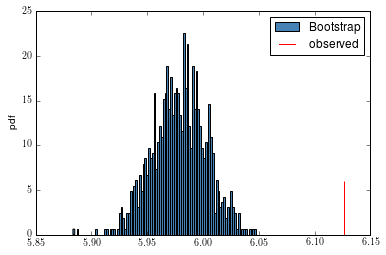

In [73]:
n, bins, patches = plt.hist(synth_othello_entropy, bins = 100, color='steelblue', normed=True, label='Bootstrap');
plt.vlines(othello_entropy, [0], max(bins), color='red', label='observed')
plt.ylabel('pdf')
plt.legend(loc='best')

Here we can see pretty clearly that synthetic dialogues don't approximate the real dialogue entropy (which is to be expected, Shakespeare wrote sentences that made sense, we just randomly picked individual ones!)

You can check and see if the same holds for Iago.

In [104]:
#Your code here


Well, since not putting nonsense words matters we could say that it's important to sample **without replacement** - we could always try to see if we could sample some subset of the original dialogue without replacement and see if that distribution approximates the real data.

Try sampling without replacement (hint use the random package, it has a function built-in)

In [105]:
#Your code here


So that's not really the right way to approach the problem of determining if the character's dialogue differs from the observed entropy. So did bootstrapping fail? 

Well...the way we set up the problem failed really! The way to really think about whether the entropies are different are to compare the observed dialogue for an individual character to the pooled dialogue for the two characters! That provides just enough randomness but keeps the important metrics constant for comparison (a fixed dialogue size and paying at least some respect to word choice not being independent). 

In [117]:
#Your code here


-0.0996194147041


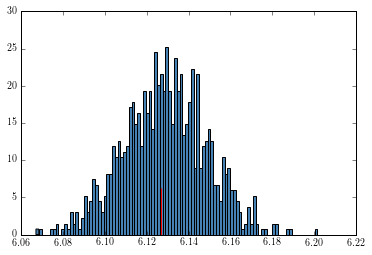

In [119]:
#Answer
import random

full_dialogue = othellos_dialogue + iagos_dialogue

synth_dialogs = [calc_entropy(random.sample(full_dialogue, len(othellos_dialogue))) \
                              for i in range(1000)]
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(synth_dialogs, bins=100, normed=True, color='steelblue')
ax.vlines(othello_entropy, [0], max(bins), color='red')

othello_zscore = (othello_entropy - np.mean(synth_dialogs))/np.std(synth_dialogs)
print(othello_zscore)

So we can see that the entropy of Othello's dialogue doesn't differ significantly from a synthetic dataset of Iago and Othello's composite dialogue. 

That is one way to say that these quantities are not different. We can also run it the other way using Iago's dialogue.

In [ ]:
#Your code here


-3.13735085702


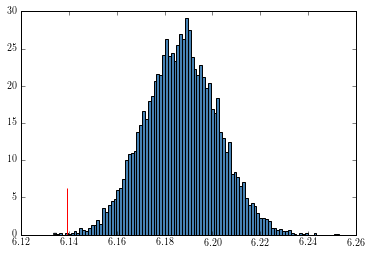

In [121]:
#Answer
iago_synth_dialogs = [calc_entropy(random.sample(full_dialogue, len(iagos_dialogue))) \
                      for i in range(10000)]
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(iago_synth_dialogs, bins=100, normed=True, color='steelblue')
ax.vlines(iago_entropy, [0], max(bins), color='red')

iago_zscore = (iago_entropy - np.mean(iago_synth_dialogs))/np.std(iago_synth_dialogs)
print(iago_zscore)

In [122]:
len(iagos_dialogue)

8330

So this would suggest that Iago's dialogue is less complex than one would expect given the number of words that he spoke. 

But there's one big problem! Our problem set-up is the problem!

Iago speaks many more words than Othello and the size of our pooled dataset is just Iago + Othello's dialogue, so that unfairly penalizes the synthetic distributions of Iago. 

To really look at this problem we need to use as our initial population the dialogue of all main characters.

So let's do this properly now.

In [143]:
#Your code here


In [137]:
#Answer
def extract_preamble():
    '''
    Extracts the othello play from the Shakespeare.txt file
    '''
    complete_works = open('../Data/Day5-Text-Analysis/Shakespeare.txt').read()
    #Cut off the beginning plays
    othello_full = complete_works.split('OTHELLO, MOOR OF VENICE\n\nby William Shakespeare\n\n\n\n')[1]
    #Cut off the plays after
    othello_text = othello_full.split('\n\n\nTHE END')[0]
    #Clean out the electronic message
    emessage = '''<<THIS ELECTRONIC VERSION OF THE COMPLETE WORKS OF WILLIAM\nSHAKESPEARE IS COPYRIGHT 1990-1993 BY WORLD LIBRARY, INC., AND IS\nPROVIDED BY PROJECT GUTENBERG ETEXT OF ILLINOIS BENEDICTINE COLLEGE\nWITH PERMISSION.  ELECTRONIC AND MACHINE READABLE COPIES MAY BE\nDISTRIBUTED SO LONG AS SUCH COPIES (1) ARE FOR YOUR OR OTHERS\nPERSONAL USE ONLY, AND (2) ARE NOT DISTRIBUTED OR USED\nCOMMERCIALLY.  PROHIBITED COMMERCIAL DISTRIBUTION INCLUDES BY ANY\nSERVICE THAT CHARGES FOR DOWNLOAD TIME OR FOR MEMBERSHIP.>>'''
    emessage_split = othello_text.split(emessage)
    #Preamble is the first part
    othello_preamble = emessage_split[0]
    return othello_preamble

preamble = extract_preamble()

import re
characters = [re.sub(',', '.', name.lstrip(' ')) for name in re.findall('[A-Z ]+,', preamble)]
character_dialogue = []
for character in characters:
    character_dialogue += [strip_punctuation(w) for w in find_character_dialogue(character, extract_othello_play())]

1.68105842044


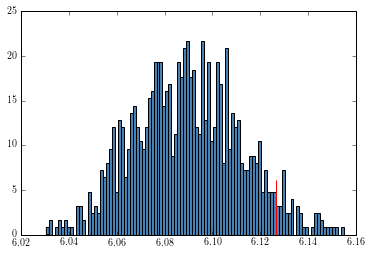

In [144]:
#Answer
othello_synth_dialogs = [calc_entropy(random.sample(character_dialogue, len(othellos_dialogue))) \
                              for i in range(1000)]
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(othello_synth_dialogs, bins=100, normed=True, color='steelblue')
ax.vlines(othello_entropy, [0], max(bins), color='red')

othello_zscore = (othello_entropy - np.mean(othello_synth_dialogs))/np.std(othello_synth_dialogs)
print(othello_zscore)

-0.386522030678


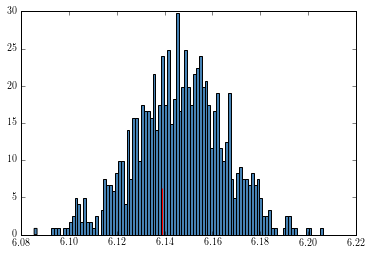

In [142]:
#Answer
iago_synth_dialogs = [calc_entropy(random.sample(character_dialogue, len(iagos_dialogue))) \
                      for i in range(1000)]
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(iago_synth_dialogs, bins=100, normed=True, color='steelblue')
ax.vlines(iago_entropy, [0], max(bins), color='red')

iago_zscore = (iago_entropy - np.mean(iago_synth_dialogs))/np.std(iago_synth_dialogs)
print(iago_zscore)

There we really go! Neither Othello or Iago's dialogue is significantly more complex than a set of sythetic dialogues that we could generate for either character from the entire pool of dialogue. 

So now we could see if one character's observed entropy differs from the synthetic distribution of the other character.

In [148]:
#Compare Iago's observed to Othello's synthetic
iago_to_othello_zscore = (iago_entropy - np.mean(othello_synth_dialogs))/ np.std(othello_synth_dialogs)
print(iago_to_othello_zscore)

2.23907095261


In [149]:
#Compare Othello's observed to Iago's synthetic
othello_to_iago_zscore = (iago_entropy - np.mean(iago_synth_dialogs))/np.std(iago_synth_dialogs)
print(othello_to_iago_zscore)

-0.386522030678


There we go! Neither character's observed dialogue entropy significantly differs from the synthetic distribution of entropies from the other character. This would suggest that the difference in language complexity between the two characters is not significant.

# Additional Exercises

In [6]:
with open('../Data/Day7-Structured-Data-Analysis/iago.json', 'r') as file1:
    iago_sentiment = json.load(file1)
    

with open('../Data/Day7-Structured-Data-Analysis/othello.json', 'r') as file1:
    othello_sentiment = json.load(file1)
    
print(len(iago_sentiment), len(othello_sentiment))

print(iago_sentiment[:10])

537 470
[1, 1, -3, 3, 1, 2, -3, 2, 3, 2]


So, are these distributions different? Let's look at some statistical metrics that might tell us something about this...

In [8]:
results_othello = stat.describe(othello_sentiment)
print(results_othello)
print()
results_iago = stat.describe(iago_sentiment)
print(results_iago)

DescribeResult(nobs=470, minmax=(-4, 4), mean=0.40851063829787232, variance=5.120609717370594, skewness=-0.41543139442792626, kurtosis=-1.3060163694576852)

DescribeResult(nobs=537, minmax=(-4, 4), mean=0.32774674115456237, variance=4.9073070402179058, skewness=-0.29978164467913276, kurtosis=-1.4307035152922654)


In [9]:
# Using t-test

t, p = stat.ttest_ind(othello_sentiment, iago_sentiment, equal_var = False)
print('ttest_ind: \t t =  {0:6.4f}  \t p = {1:6.4f}'.format(t, p) )

ttest_ind: 	 t =  0.5706  	 p = 0.5684


In [10]:
# Using Kolmogorov-Smirnov test

D, p = stat.ks_2samp(othello_sentiment, iago_sentiment)
print('KS 2 samp: \t  D =  {0:6.4f}  \t p = {1:6.4f}'.format(D, p) )

KS 2 samp: 	  D =  0.0272  	 p = 0.9916


In [12]:
# Using chi_square test

hist_othello, edges = np.histogram(othello_sentiment, bins = 6, density = True)
hist_iago, edges = np.histogram(iago_sentiment, bins = 6, density = True)

hist_othello = 100 * np.array(hist_othello)
hist_iago = 100 * np.array(hist_iago)
print(hist_othello)
print(hist_iago)

b = (hist_othello - hist_iago)**2 / hist_iago
print(b)
print(np.cumsum( b ))

chi2 , p = stat.chisquare(hist_othello, hist_othello, ddof = 5)
print(chi2, p)



[  9.57446809  14.04255319   5.90425532   9.73404255  21.70212766
  14.04255319]
[  8.51955307  16.34078212   6.70391061   9.3575419   20.81005587
  13.26815642]
[ 0.13062254  0.32323154  0.09538441  0.0151485   0.03824075  0.04519771]
[ 0.13062254  0.45385409  0.5492385   0.564387    0.60262775  0.64782546]
0.0 nan


In [14]:
import math

# Playing games of chance

# Define outcomes of play
one_die = range(1, 7)

cards = []
card_values = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 
               'Jack', 'Queen', 'King', 'Ace']
suites = ['Clubs', 'Diamonds', 'Hearts', 'Spades']
for value in card_values:
    for suit in suites:
        cards.append(value + " " + suit)

        
no_one_die = len(one_die)
no_cards = len(cards)

print( no_one_die, one_die )
print()
print( no_cards, cards )

6 range(1, 7)

52 ['2 Clubs', '2 Diamonds', '2 Hearts', '2 Spades', '3 Clubs', '3 Diamonds', '3 Hearts', '3 Spades', '4 Clubs', '4 Diamonds', '4 Hearts', '4 Spades', '5 Clubs', '5 Diamonds', '5 Hearts', '5 Spades', '6 Clubs', '6 Diamonds', '6 Hearts', '6 Spades', '7 Clubs', '7 Diamonds', '7 Hearts', '7 Spades', '8 Clubs', '8 Diamonds', '8 Hearts', '8 Spades', '9 Clubs', '9 Diamonds', '9 Hearts', '9 Spades', '10 Clubs', '10 Diamonds', '10 Hearts', '10 Spades', 'Jack Clubs', 'Jack Diamonds', 'Jack Hearts', 'Jack Spades', 'Queen Clubs', 'Queen Diamonds', 'Queen Hearts', 'Queen Spades', 'King Clubs', 'King Diamonds', 'King Hearts', 'King Spades', 'Ace Clubs', 'Ace Diamonds', 'Ace Hearts', 'Ace Spades']


In [16]:
#How many possibilities
def number_states_dice(n, no_one_die = 6):
    """ Returns number of possible sums for n dice""" 
    return 6*n - (n-1)

def number_states_cards(n, no_cards = 52):
    """ Returns number of possible hands of n cards from a single deck""" 
    number = 1
    for i in range(no_cards, no_cards-n, -1):
        number *= i
    return number / math.factorial(n)


print( number_states_dice(3) )
print( number_states_cards(15) )

16
4481381406320.0


In [17]:
import numpy as np

def prob_of_outcome_tossing_n_dice(sum_dots, n, n_attempts = 1000):
    """ Probability of the sum of the dots in n dice being sum_dots"""
    count_successes = 0
    for a in range(n_attempts):
        # Toss dice
        sum_temp = 0
        for i in range(n):
            sum_temp += np.random.randint(6) + 1
        if sum_temp == sum_dots:
            count_successes += 1
    
    return float(count_successes) / n_attempts

print( prob_of_outcome_tossing_n_dice(3, 2, 10) )
print( prob_of_outcome_tossing_n_dice(3, 2, 100) )
print( prob_of_outcome_tossing_n_dice(3, 2) )
print( prob_of_outcome_tossing_n_dice(3, 2, 1000000) )

0.0
0.13
0.056
0.055795


0.0238


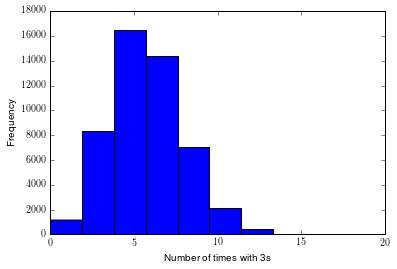

In [19]:
#0.055917 * 100
Number_of_times_I_observed_3 = 11

count_3s = []
extreme = 0
for i in range(50000):
    outcome = 100 * prob_of_outcome_tossing_n_dice(3, 2, 100)
    count_3s.append( outcome )
    if outcome >= 11:
        extreme += 1

print( extreme / float(50000) )
plt.hist(count_3s)
plt.xlabel("Number of times with 3s")
plt.ylabel("Frequency")

plt.show()


In [20]:
# Calculate pi by calculating area of quarter circle

def estimate_pi(n_attempts = 10000):
    """ Estimate pi from area of quarter circle """ 
    count_successes = 0
    for i in range(n_attempts):
        x_rand = np.random.random()
        y_rand = np.random.random()
        dist = math.sqrt( x_rand **2 + y_rand**2 )
        if dist <= 1.:
            count_successes += 1
    return float(count_successes) / n_attempts


print( math.pi / 4. )
print( estimate_pi(10) )

0.7853981633974483
0.9


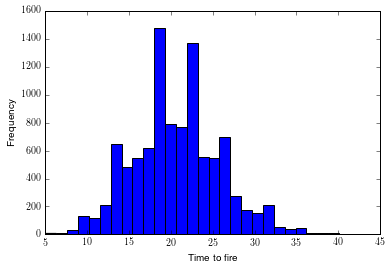

In [22]:
# Calculate distribution of firing times of a model neuron

def time_to_fire( threshold , lamb, scale_size):
    """ Simulate distribution of times for neuron that sums
    inputs and fires when sum exceeds threshold """
    state = 0.
    time = 0.
    while state < threshold: 
        # Update time
        delay_between_inputs = np.random.poisson(lamb)
        time += delay_between_inputs
        
        # Update state
        size_of_input = scale_size * np.random.random()
        state += size_of_input
        
    return time    

# Initialize variables
N_neurons = 10000
threshold = 1.
scale_size = 0.1
lamb = 1.

list_times = []
for neuron in range(N_neurons):
    list_times.append( time_to_fire( threshold , lamb, scale_size) )

    
#print list_times

plt.hist(list_times, 30)
plt.xlabel("Time to fire")
plt.ylabel("Frequency")

plt.show()
